In [1]:
import struct
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Okay, this is for using GPU POWEEEER
import cupy as cp

print(cp.cuda.runtime.getDeviceCount())

1


# Reading Data

In [2]:
def load_images(path: str):
    # Images in 784x1 format
    images = []
    
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n, rows, cols = struct.unpack('>IIII', f.read(16))
        
        for _ in range(n):
            # Read and unpack image (which has 28x28 bytes)
            image = list(struct.unpack('>' + 'B' * (rows * cols), f.read(rows * cols)))
            images.append(image)
    
    return np.array(images)

In [3]:
def load_labels(path: str):
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n = struct.unpack('>II', f.read(8))
        
        # Read and return labels
        return np.array(struct.unpack('>' + 'B' * n, f.read(n)))

In [4]:
def save_file(path, data):
    with open(path, 'wb') as f:
        f.write(data)

In [5]:
train_images_path = "train-images.idx3-ubyte"
train_labels_path = "train-labels.idx1-ubyte"
test_images_path = "t10k-images.idx3-ubyte"
test_labels_path = "t10k-labels.idx1-ubyte"

train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

## Whitening (Z-Scoring) data

In [6]:
def z_score(data):
    mean = np.mean(data)
    std = np.std(data)
    return mean, std, (data - mean) / std

In [7]:
mean, std, train_images = z_score(train_images)

In [8]:
test_images = (test_images - mean) / std

In [9]:
save_file("preprocessed_data/train_images", train_images)
save_file("preprocessed_data/test_images", test_images)

# Re-shape and Visualization

In [10]:
def reshape_matrix_to_images(matrix_images):
    apply_function = lambda row: row.reshape((28, 28))
    return np.apply_along_axis(apply_function, axis=1, arr=matrix_images)

In [11]:
def plot_image(reshaped_image, label = ""):
    plt.imshow(reshaped_image, cmap=plt.get_cmap('gray'))
    if label != "":
        plt.title(f"Label: {label}")
    plt.show()

## Checking image-label pair

### Train Data

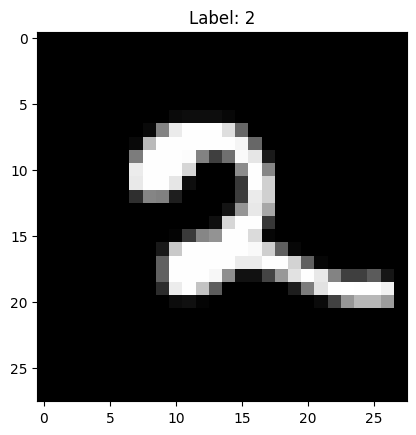

In [12]:
reshaped_images = reshape_matrix_to_images(train_images)
rand_index = np.random.randint(0, len(train_images))
plot_image(reshaped_images[rand_index], train_labels[rand_index])

In [13]:
def one_hot_encoding(labels):
    one_hot_encoded_labels = []
    for i, label in enumerate(labels):
        one_hot_label = np.zeros(10)
        one_hot_label[label] = 1.0
        one_hot_encoded_labels.append(one_hot_label)
    
    return np.array(one_hot_encoded_labels)

In [14]:
def one_hot_decoding(one_hot_encoded_labels):
    if len(one_hot_encoded_labels.shape) == 1:
        return np.argmax(one_hot_encoded_labels)
    return np.argmax(one_hot_encoded_labels, axis=1)

In [15]:
train_encoded_labels = one_hot_encoding(train_labels)
test_encoded_labels = one_hot_encoding(test_labels)

## Checking 'one_hot_encoding' function working correct

In [16]:
train_encoded_labels[8:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [17]:
train_labels[8:10]

array([1, 4])

In [18]:
one_hot_decoding(train_encoded_labels[8:10])

array([1, 4])

# NN

## Activation Functions

In [19]:
from abc import ABC, abstractmethod


class ActivationFunction(ABC):
    def __init__(self, cuda=False):
        self.cuda = cuda
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def derivatives(self, x):
        pass

class Relu(ActivationFunction):
    def forward(self, x):
        if self.cuda:
            return cp.maximum(0, x)
        
        return np.maximum(x, 0)
    
    def derivatives(self, x):
        if self.cuda:
            x = cp.asarray(x)
        
        return x > 0

class Softmax(ActivationFunction):
    def forward(self, x):
        if self.cuda:
            x = cp.asarray(x)
            exps = cp.exp(x - cp.max(x))
            return exps / cp.sum(exps)
            
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)
    
    def derivatives(self, x):
        return 1

## Weight Initializers

In [20]:
class WeightInitializer(ABC):
    @abstractmethod
    def init(self, n_in, n_out, cuda=False):
        pass
    
class NormalInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.standard_normal(size=(n_in, n_out))
        
        return np.random.standard_normal(size=(n_in, n_out))
    
class XavierInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.normal(0, 1/n_in, size=(n_in, n_out))
        
        return np.random.normal(0, 1/n_in, size=(n_in, n_out))

# Weights initializer from given research paper and yes, it works SUPER
class PaperInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))
        
        return np.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))

## Optimizers

In [29]:
class Optimizer(ABC):
    def __init__(self, cuda=False):
        self.weights = None
        self.bias = None
        self.cuda = cuda
    
    def set_weights_and_bias(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
    def convert_to_cupy_array(self, dW, db):
        return cp.asarray(dW), cp.asarray(db)
    
    @abstractmethod
    def optimize(self, hyperparams, dW, db):
        pass

class SGD(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.weights -= lr * dW
        self.bias -= lr * db

class Momentum(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.v = 0
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta = hyperparams["beta1"]
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.v = beta * self.v + (1 - beta) * dW
        
        self.weights -= lr * self.v
        self.bias -= lr * db
        
class RMSProp(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.s = 0
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta2 = hyperparams['beta2']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        dW = dW ** 2
        
        self.s = beta2 * self.s + (1 - beta2) * dW
        
        self.weights -= lr * dW / np.sqrt(self.s + 1e-10)
        self.bias -= lr * db
        
class Adam(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.v = 0
        self.s = 0
        
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta1 = hyperparams['beta1']
        beta2 = hyperparams['beta2']
        epochs = hyperparams['epochs']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.v = beta1 * self.v + (1 - beta1) * dW
        self.s = beta2 * self.s + (1 - beta2) * dW**2
        
        self.weights -= lr * self.v / np.sqrt(self.s + 1e-10)
        self.bias -= lr * db
        
        self.v = self.v / (1.0 - np.pow(beta1, epochs))
        self.s = self.s / (1.0 - np.pow(beta2, epochs))

## Loss Functions

In [24]:
class LossFunction(ABC):
    def __init__(self, cuda=False):
        self.cuda = cuda
    
    @abstractmethod
    def loss(self, y_pred, y_true):
        pass
    
    @abstractmethod
    def gradient(self, y_pred, y_true):
        pass

class MSE(LossFunction):
    def loss(self, y_pred, y_true):
        if self.cuda:
            return cp.mean((y_pred - y_true) ** 2)
        
        return np.mean((y_pred - y_true) ** 2)
    
    def gradient(self, y_pred, y_true):
        return y_pred - y_true

In [203]:
class Layer:
    def __init__(self, n_in, n_out, is_output = False,
                 weight_init: WeightInitializer = PaperInitializer(),
                 activation: str = "relu",
                 optimizer = "momentum",
                 cuda=False):
        self.n_in = n_in
        self.n_out = n_out
        self.is_output = is_output
        
        self.cuda = cuda
        
        self.weight_init = weight_init
        
        if activation == "relu":
            self.activation = Relu(self.cuda)
        elif activation == "softmax":
            self.activation = Softmax(self.cuda)
        
        optimizer = optimizer.lower()
        if optimizer == "sgd":
            self.optimizer = SGD(self.cuda)
        elif optimizer == "momentum":
            self.optimizer = Momentum(self.cuda)
        elif optimizer == "rmsprop":
            self.optimizer = RMSProp(self.cuda)
        elif optimizer == "adam":
            self.optimizer = Adam(self.cuda)
        
        self.weights = self.weight_init.init(n_in, n_out, self.cuda)
        
        if self.cuda:
            self.bias = cp.zeros((1, n_out))
        else:
            self.bias = np.zeros((1, n_out))
        
        self.optimizer.set_weights_and_bias(self.weights, self.bias)
        
        self.A_prev = None
        self.Z = None
        
        self.Z_mean = None
        self.Z_std = None
        
        self.v = 0
    
    def forward(self, A_prev, is_training = True):
        if self.cuda:
            self.A_prev = A_prev
            self.Z = cp.dot(A_prev, self.weights) + self.bias
            
            if is_training and self.Z.shape[0] != 1:
                self.Z_mean = cp.mean(self.Z, axis = 0)
                self.Z_std = cp.std(self.Z, axis = 0)
    
            if self.Z_mean is not None and self.Z_std is not None:    
                self.Z = (self.Z - self.Z_mean) / self.Z_std
            
            return self.activation.forward(self.Z)
        else:
            self.A_prev = A_prev
            self.Z = np.dot(A_prev, self.weights) + self.bias
            
            if is_training and self.Z.shape[0] != 1:
                self.Z_mean = np.mean(self.Z, axis = 0)
                self.Z_std = np.std(self.Z, axis = 0)
    
            if self.Z_mean is not None and self.Z_std is not None:    
                self.Z = (self.Z - self.Z_mean) / self.Z_std
            
            return self.activation.forward(self.Z)

    def backprop(self, dZ_prev, m, is_batch_mode=False):
        if self.cuda:
            if self.is_output:
                dZ = dZ_prev
            else:
                dZ = dZ_prev * self.activation.derivatives(self.Z)
                
            if is_batch_mode:
                dW = 0
                dZ_next = []
                for i in range(dZ_prev.shape[0]):
                    dW += 1/m * cp.dot(self.A_prev[:,i], dZ[i,:])
                    dZ_next.append(cp.dot(dZ[i,:], self.weights.T))
                
                dW /= dZ_prev.shape[0]
                dZ_next = cp.vstack(tuple(dZ_next))
            else:
                dW = 1/m * cp.dot(self.A_prev.T, dZ)
                dZ_next = cp.dot(dZ, self.weights.T)
            
            db = 1/m * cp.sum(dZ, axis=0, keepdims=True) / dZ_prev.shape[0]
            
            return dZ_next, dW, db
        else:
            if self.is_output:
                dZ = dZ_prev
            else:
                dZ = dZ_prev * self.activation.derivatives(self.Z)
                
            if is_batch_mode:
                dW = 0
                dZ_next = []
                for i in range(dZ_prev.shape[0]):
                    dW += 1/m * np.dot(self.A_prev[:,i], dZ[i,:])
                    dZ_next.append(np.dot(dZ[i,:], self.weights.T))
                
                dW /= dZ_prev.shape[0]
                dZ_next = np.vstack(tuple(dZ_next))
            else:
                dW = 1/m * np.dot(self.A_prev.T, dZ)
                dZ_next = np.dot(dZ, self.weights.T)
            
            db = 1/m * np.sum(dZ, axis=0, keepdims=True) / dZ_prev.shape[0]
            
            return dZ_next, dW, db
    
    def update(self, hyperparams, dW, db):
        self.optimizer.optimize(hyperparams, dW, db)

In [204]:
class NN:
    def __init__(self, layers: List[Layer], hyperparams: dict, loss_function: LossFunction, cuda=False):
        self.layers = layers
        self.layers[-1].is_output = True
        
        self.hyperparams = hyperparams
        
        self.loss_function = loss_function
        
        self.cuda = cuda
    
    def forward(self, X, is_training = True):
        if self.cuda:
            X = cp.asarray(X)
        
        if len(X.shape) == 1:
            A_prev = X.reshape((1, X.shape[0]))
        else:
            A_prev = X
            
        for layer in self.layers:
            A_prev = layer.forward(A_prev, is_training)
        
        return A_prev
    
    def backprop(self, y_pred, y_true, is_batch_mode=False):
        if self.cuda:
            y_pred = cp.asarray(y_pred)
            y_true = cp.asarray(y_true)
        
        dZ = self.loss_function.gradient(y_pred, y_true)
        
        for layer in self.layers[::-1]:
            dZ, dW, db = layer.backprop(dZ, y_true.shape[0], is_batch_mode)
            layer.update(self.hyperparams, dW, db)
    
    def accuracy(self, y_pred, y_true):
        axis = len(y_true.shape) - 1
        decoded_y_pred = np.argmax(y_pred, axis = axis)
        decoded_y_true = np.argmax(y_true, axis = axis)
        return np.sum(decoded_y_pred == decoded_y_true) / y_true.shape[0]
    
    def train(self, train_set, train_label_set, test_set, test_label_set, epochs = 10000, is_batch_mode=False, batch_size=100, decay_step = 100, decay_rate = 0.96):
        if self.cuda:
            train_set = cp.asarray(train_set)
            train_label_set = cp.asarray(train_label_set)
            test_set = cp.asarray(test_set)
            test_label_set = cp.asarray(test_label_set)
        
        self.hyperparams["epochs"] = epochs
        
        train_losses = []
        test_losses = []
        
        avg_train_loss = 0
        avg_test_loss = 0
        
        batch_count = train_set.shape[0] // batch_size
        
        for epoch in tqdm(range(epochs + 1)):
            if is_batch_mode:
                rand_batch_idx = np.random.randint(0, batch_count - 1)
                start = rand_batch_idx * batch_size
                end = min((rand_batch_idx + 1) * batch_size, train_set.shape[0])
                X = train_set[start:end]
                y = train_label_set[start:end]
            else:
                rand_idx = np.random.randint(0, train_set.shape[0])
                X = train_set[rand_idx]
                y = train_label_set[rand_idx]
            
            y_pred = self.forward(X)
            
            training_loss = self.loss_function.loss(y_pred, y)
            avg_train_loss += training_loss
            
            self.backprop(y_pred, y)
            
            rand_idx = np.random.randint(0, test_set.shape[0])
            X_test = test_set[rand_idx]
            y_test = test_label_set[rand_idx]
            
            test_y_pred = self.forward(X_test, is_training = False)
            test_loss = self.loss_function.loss(test_y_pred, y_test)
            avg_test_loss += test_loss
            
            if epoch % decay_step == 0 and epoch > 0:
                hyperparams["learning_rate"] *= decay_rate
                
                avg_train_loss /= decay_step
                avg_test_loss /= decay_step
                
                if self.cuda:
                    test_losses.append(avg_test_loss.get())
                    train_losses.append(avg_train_loss.get())
                else:
                    test_losses.append(avg_test_loss)
                    train_losses.append(avg_train_loss)
                
                print(f"Loss (train) {epoch }: {avg_train_loss}")
                print(f"Loss (test) {epoch}: {avg_test_loss}")
                
                avg_train_loss = 0
                avg_test_loss = 0
        
        return train_losses, test_losses

# Experiment

In [205]:
class ExperimentManager:
    def __init__(self, experiment_folder: str):
        self.experiment_name = experiment_folder
        
        self.train_set = None
        self.train_label_set = None
        self.validation_set = None
        self.validation_label_set = None
        self.test_set = None
        self.test_label_set = None
    
    def load_data(self, train_data, train_labels, test_data, test_labels, train_portion = 0.75):
        perm = np.random.permutation(train_images.shape[0])
        
        self.train_set = train_data[perm[:int(train_portion * train_data.shape[0])]]
        self.train_label_set = train_labels[perm[:int(train_portion * train_labels.shape[0])]]
        
        self.validation_set = train_data[perm[int(train_portion * train_data.shape[0]):]]
        self.validation_label_set = train_labels[perm[int(train_portion * train_labels.shape[0]):]]
        
        self.test_set = test_data
        self.test_label_set = test_labels
    
    def experiment(self, experiment_name: str, nn: NN, epochs = 10000, is_batch_mode=False, batch_size=100, decay_step = 100, decay_rate = 0.96):
        train_losses, validation_losses = nn.train(self.train_set, self.train_label_set, self.validation_set, self.validation_label_set,
                                                   epochs, is_batch_mode, batch_size, decay_step, decay_rate)
        plt.plot(range(0, epochs, decay_step), train_losses, label='train')
        plt.plot(range(0, epochs, decay_step), validation_losses, label='validation')
        plt.show()
        
        cuda = nn.cuda
        
        output = nn.forward(self.test_set, is_training = False)
        if cuda:
            output = output.get()
        acc = nn.accuracy(output, test_encoded_labels)
        output = one_hot_decoding(output)
        
        cf_matrix = confusion_matrix(test_labels, output)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
        cm_display.plot()
        plt.suptitle(f"Accuracy on test set: {acc * 100:.2f}%")
        plt.savefig('results.png')

## Initialization of NN with distinct params

In [214]:
epochs = 10000
decay_step = epochs // 100

hyperparams = {
    "learning_rate": 0.1,
    "beta1": 0.9,
    "beta2": 0.999,
}

is_batch_mode = False
batch_size = 100

cuda = True

nn = NN(layers=[
    Layer(784, 512, cuda=cuda),
    Layer(512, 10, activation="softmax", cuda=cuda),
], hyperparams=hyperparams, loss_function=MSE(), cuda=cuda)

  0%|          | 0/10001 [00:00<?, ?it/s]

Loss (train) 100: 0.07173370419566853
Loss (test) 100: 0.0708137018990825
Loss (train) 200: 0.0531297473030514
Loss (test) 200: 0.046476370502830947
Loss (train) 300: 0.035104684627606055
Loss (test) 300: 0.0425770014965886
Loss (train) 400: 0.035632348743671556
Loss (test) 400: 0.027981353044060735
Loss (train) 500: 0.03372123340957677
Loss (test) 500: 0.027590046023781793
Loss (train) 600: 0.02421285383270995
Loss (test) 600: 0.03223282134250626
Loss (train) 700: 0.036193407712191504
Loss (test) 700: 0.027921140309322273
Loss (train) 800: 0.0328570173861098
Loss (test) 800: 0.02817912087904338
Loss (train) 900: 0.022063058304408086
Loss (test) 900: 0.02236818832960115
Loss (train) 1000: 0.027317932325917303
Loss (test) 1000: 0.027880928771537652
Loss (train) 1100: 0.01302628352378575
Loss (test) 1100: 0.01744668864118144
Loss (train) 1200: 0.012611626877326481
Loss (test) 1200: 0.015145959641169014
Loss (train) 1300: 0.01408581321557222
Loss (test) 1300: 0.017725726508764934
Loss (tr

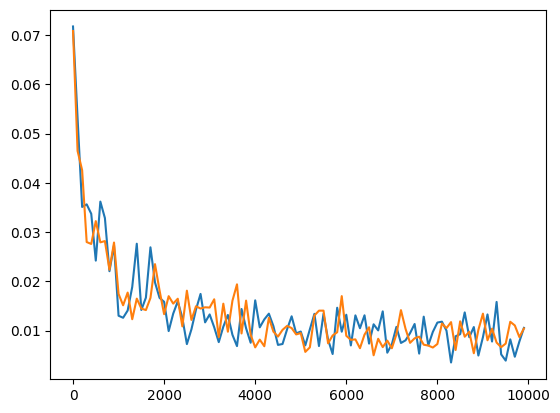

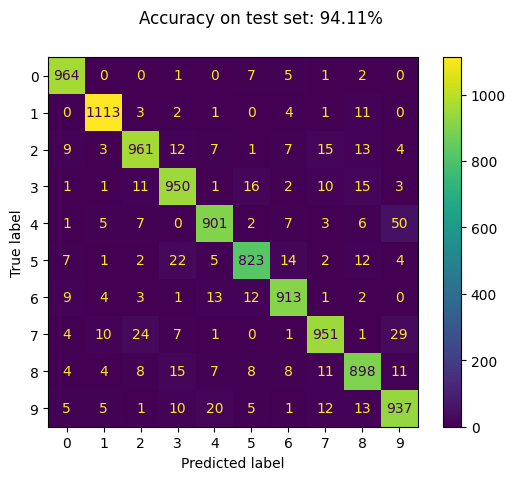

In [215]:
em = ExperimentManager("test")
em.load_data(train_images, train_encoded_labels, test_images, test_encoded_labels)
em.experiment("test1", nn, epochs = epochs, is_batch_mode = is_batch_mode, batch_size = batch_size)

## Plotting weights from first layer (just for fun and maybe see some insights)

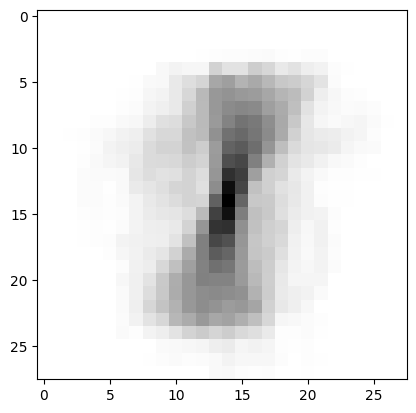

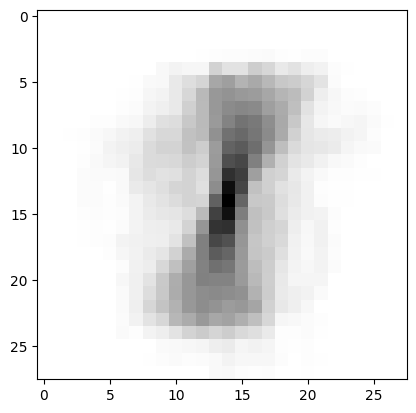

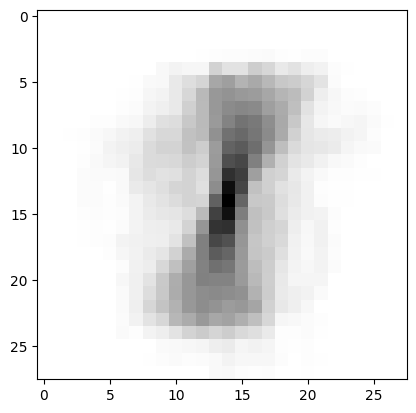

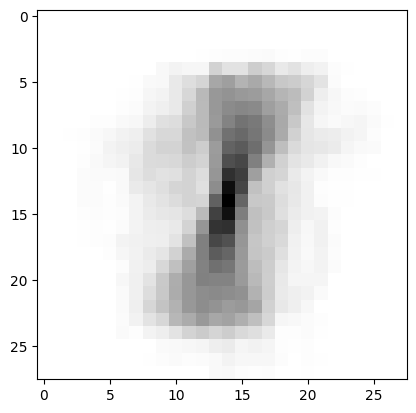

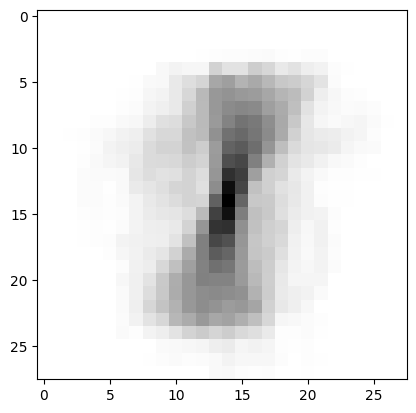

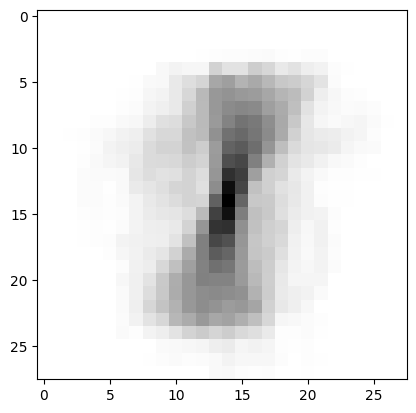

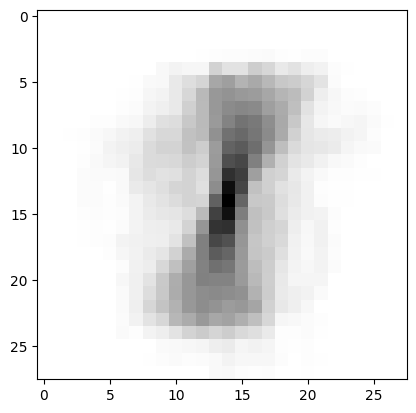

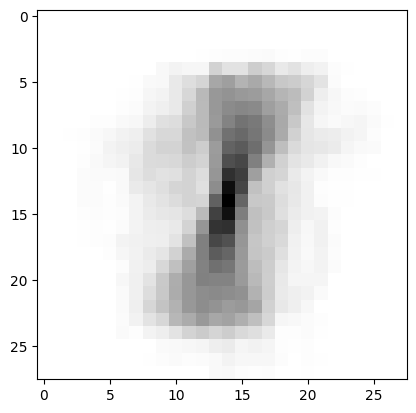

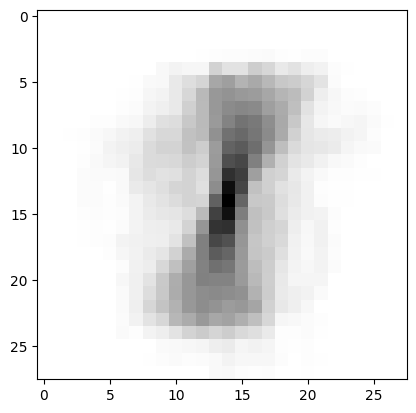

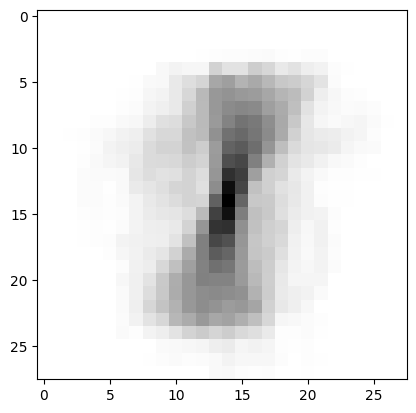

In [213]:
for i in range(10):
    first_layer_weights = nn.layers[0].weights[:,i].reshape((28, 28)) 
    if cuda:
        first_layer_weights = first_layer_weights.get()
    plot_image(first_layer_weights)